In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Loading data

In [3]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
# Ensure proper time ordering within each stock
train = train.sort_values(['STOCK', 'DATE']).reset_index()
test  = test.sort_values(['STOCK', 'DATE']).reset_index()
train.head()

,ID,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
0,2377,1,0,37,12,5,94,-0.005967,0.136699,0.009031,...,-0.493354,-0.007660,-0.585497,-0.001063,-0.351363,0.005127,-0.324675,-0.019275,-0.291751,False
1,5198,4,0,37,12,5,94,0.001348,-0.269520,0.011100,...,-0.313575,0.007867,0.071338,0.007733,-0.405243,-0.003276,-0.424336,-0.010489,-0.050591,False
2,8017,5,0,37,12,5,94,-0.014405,0.192655,0.003614,...,-0.367499,-0.005843,-0.405562,0.002930,-0.315935,0.010462,-0.474957,-0.003541,-0.260130,True
3,20826,11,0,37,12,5,94,0.008938,0.430916,0.002662,...,0.023598,0.011266,0.079711,0.019038,-0.230167,-0.000287,-0.312123,0.008682,-0.226628,True
4,33843,21,0,37,12,5,94,-0.006523,-0.060371,-0.007632,...,-0.337686,-0.007224,-0.161117,-0.001461,-0.095494,0.012667,0.471895,-0.038752,1.532045,False


# Feature Engineering
Compare to v0, this version has: 

Cross-sectional rank

- Full rank for all RET1...20 (v0 only has RET1, 5, etc.)
- Sector-within-date rank -> Is this stock good relative to its sector today
- Volume rank -> attention, liquidity factor

Sector-relative
- Ret vs sector mediann, percentage rank (v0 only has mean, sd per stock over 20 days)

Composite momentum & vol cluster features
- momentum1_5, 6_20 averages and ranks -> short-term, medium-term trend, top momentum of the day
- vol5d and vol5d pct rank -> std per row, rank within date
- ret vol ratio and rank -> Sharpe-like ratio

In [4]:
# ============================================================================
# ENHANCED CROSS-SECTIONAL FEATURES 
# ============================================================================
print("="*80)
print("ENHANCED CROSS-SECTIONAL FEATURES")
print("="*80)

def create_enhanced_cross_sectional_features(df):
    """
    Focus on relative ranking - the KEY to predicting top 50%
    """
    df_new = df.copy()
    
    print("  Creating enhanced rank-based features...")
    
    if 'DATE' not in df_new.columns:
        return df_new
    
    # 1. PERCENTILE RANKS (Most Important!)
    for col in [f'RET_{i}' for i in range(1, 21)]:
        if col in df_new.columns:
            # Date-level rank
            df_new[f'{col}_pctrank'] = df_new.groupby('DATE')[col].rank(pct=True)
    
    # 2. SECTOR-RELATIVE RANKS
    if 'SECTOR' in df_new.columns:
        for col in [f'RET_{i}' for i in range(1, 11)]:
            if col in df_new.columns:
                df_new[f'{col}_sector_pctrank'] = df_new.groupby(['DATE', 'SECTOR'])[col].rank(pct=True)
    
    # 3. VOLUME RANKS (liquidity matters!)
    for col in [f'VOLUME_{i}' for i in range(1, 11) if f'VOLUME_{i}' in df_new.columns]:
        df_new[f'{col}_pctrank'] = df_new.groupby('DATE')[col].rank(pct=True)
    
    # 4. CROSS-SECTIONAL Z-SCORES (alternative to ranks)
    for col in [f'RET_{i}' for i in range(1, 11)]:
        if col in df_new.columns:
            df_new[f'{col}_cs_zscore'] = df_new.groupby('DATE')[col].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
    
    # 5. RELATIVE TO SECTOR MEDIAN (deviation from peers)
    if 'SECTOR' in df_new.columns:
        for col in [f'RET_{i}' for i in range(1, 6)]:
            if col in df_new.columns:
                sector_median = df_new.groupby(['DATE', 'SECTOR'])[col].transform('median')
                df_new[f'{col}_vs_sector_med'] = df_new[col] - sector_median
    
    # 6. COMPOSITE MOMENTUM RANKS
    df_new['momentum_1_5'] = df_new[[f'RET_{i}' for i in range(1, 6)]].mean(axis=1)
    df_new['momentum_1_5_pctrank'] = df_new.groupby('DATE')['momentum_1_5'].rank(pct=True)
    
    df_new['momentum_6_20'] = df_new[[f'RET_{i}' for i in range(6, 21)]].mean(axis=1)
    df_new['momentum_6_20_pctrank'] = df_new.groupby('DATE')['momentum_6_20'].rank(pct=True)
    
    # 7. VOLATILITY RANKS (risk-adjusted)
    df_new['vol_5d'] = df_new[[f'RET_{i}' for i in range(1, 6)]].std(axis=1)
    df_new['vol_5d_pctrank'] = df_new.groupby('DATE')['vol_5d'].rank(pct=True)
    
    # 8. RETURN-TO-VOLATILITY RATIO (Sharpe-like)
    df_new['ret_vol_ratio'] = df_new['momentum_1_5'] / (df_new['vol_5d'] + 1e-8)
    df_new['ret_vol_ratio_pctrank'] = df_new.groupby('DATE')['ret_vol_ratio'].rank(pct=True)
    
    return df_new

# Apply enhanced features
print("\nApplying to train...")
train_eng = create_enhanced_cross_sectional_features(train)
print(f"✓ Train shape: {train_eng.shape}")

print("\nApplying to test...")
test_eng = create_enhanced_cross_sectional_features(test)
print(f"✓ Test shape: {test_eng.shape}")


ENHANCED CROSS-SECTIONAL FEATURES

Applying to train...
  Creating enhanced rank-based features...
✓ Train shape: (418595, 111)

Applying to test...
  Creating enhanced rank-based features...
✓ Test shape: (198429, 110)


In [5]:
# ============================================================================
# PREPARE DATA FOR MODELING
# ============================================================================
print("="*80)
print("DATA PREPARATION")
print("="*80)

# Define feature columns
categorical_cols = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']
exclude_cols = ['ID', 'RET'] + categorical_cols

# Get all numeric features
feature_cols = [col for col in train_eng.columns if col not in exclude_cols]
print(f"Total features: {len(feature_cols)}")

# Prepare X and y
X_train = train_eng[feature_cols].copy()
y_train = train_eng['RET'].astype(int)
groups_train = train_eng['DATE'].values

X_test = test_eng[feature_cols].copy()

# Handle missing values - simple median imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"✓ Training shape: {X_train_imputed.shape}")
print(f"✓ Test shape: {X_test_imputed.shape}")
print(f"✓ Missing values: {X_train_imputed.isnull().sum().sum()}")


DATA PREPARATION
Total features: 103
✓ Training shape: (418595, 103)
✓ Test shape: (198429, 103)
✓ Missing values: 0


In [6]:
# ============================================================================
# FEATURE SELECTION (OPTIMIZED FOR GENERALIZATION)
# ============================================================================
print("\n" + "="*80)
print("FEATURE SELECTION - PRIORITIZING CROSS-SECTIONAL")
print("="*80)

# Prepare features
categorical_cols = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']
exclude_cols = ['ID', 'RET'] + categorical_cols
all_features = [col for col in train_eng.columns if col not in exclude_cols]

# Prioritize ONLY percentile rank features (most robust)
rank_features = [f for f in all_features if 'pctrank' in f] #or 'cs_zscore' in f]

# Filter: Keep only RET and momentum rank features (most predictive)
ret_rank_features = [f for f in rank_features if 'RET_' in f]
momentum_features = [f for f in rank_features if 'momentum' in f]
vol_features = [f for f in rank_features if 'vol' in f or 'ret_vol_ratio' in f]

# Combine core features
core_rank_features = ret_rank_features + momentum_features + vol_features

print(f"Core rank features: {len(core_rank_features)}")
print(f"  - RET rank features: {len(ret_rank_features)}")
print(f"  - Momentum features: {len(momentum_features)}")
print(f"  - Volatility features: {len(vol_features)}")

# Get raw features (non-rank) for correlation analysis
raw_features = [f for f in all_features if f not in rank_features]

# Calculate correlation with target for raw features
from scipy.stats import spearmanr
correlations = []
y_binary = train_eng['RET'].astype(int)

for col in raw_features:
    try:
        corr, _ = spearmanr(train_eng[col].fillna(0), y_binary)
        correlations.append({'feature': col, 'corr': abs(corr)})
    except:
        pass

corr_df = pd.DataFrame(correlations).sort_values('corr', ascending=False)

top_raw_features = corr_df.head(15)['feature'].tolist()  # ✅ Increase from 15

# Final feature set
selected_features = core_rank_features + top_raw_features

print(f"\nFinal feature count: {len(selected_features)}")
print(f"  - Rank features: {len(core_rank_features)}")
print(f"  - Top raw features: {len(top_raw_features)}")
print(f"\nTop 10 raw features by correlation:")
print(corr_df.head(10))

# Prepare data
X_train = train_eng[selected_features].copy()
y_train = train_eng['RET'].astype(int)
groups_train = train_eng['DATE'].values

X_test = test_eng[selected_features].copy()

# Impute
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"\n✓ Training set: {X_train_imputed.shape}")
print(f"✓ Test set: {X_test_imputed.shape}")
print(f"✓ Reduced from 84 to {len(selected_features)} features")



FEATURE SELECTION - PRIORITIZING CROSS-SECTIONAL
Core rank features: 34
  - RET rank features: 30
  - Momentum features: 2
  - Volatility features: 2

Final feature count: 49
  - Rank features: 34
  - Top raw features: 15

Top 10 raw features by correlation:
                feature      corr
57               vol_5d  0.026120
40      RET_1_cs_zscore  0.022708
50  RET_1_vs_sector_med  0.022369
1              VOLUME_1  0.017552
0                 RET_1  0.016728
41      RET_2_cs_zscore  0.013086
55         momentum_1_5  0.013060
49     RET_10_cs_zscore  0.011634
51  RET_2_vs_sector_med  0.011119
35            VOLUME_18  0.010130

✓ Training set: (418595, 49)
✓ Test set: (198429, 49)
✓ Reduced from 84 to 49 features


## Model

In [41]:
# ============================================================================
# TRAINING MODELS 
# ============================================================================
def train_model_cv(X, y, dates, model_name='xgb', n_folds=5):
    """Simplified CV training with standard threshold (0.5)"""
    
    gkf = GroupKFold(n_splits=n_folds)
    results = []
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=dates)):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        # Train model
        if model_name == 'xgb':
            model = xgb.XGBClassifier(
                n_estimators=300,
                max_depth=5,
                learning_rate=0.03,
                subsample=0.7,
                colsample_bytree=0.6,
                reg_alpha=0.8,
                reg_lambda=2.5,
                random_state=42 + fold,
                n_jobs=-1,
                use_label_encoder=False
            )
        elif model_name == 'lgb':
            model = lgb.LGBMClassifier(
                n_estimators=300,
                max_depth=5,
                learning_rate=0.02,
                subsample=0.7,
                colsample_bytree=0.7,
                min_child_samples=30,
                reg_alpha=1.5,
                reg_lambda=3.5,
                random_state=42 + fold,
                n_jobs=-1,
                verbose=-1
            )
        elif model_name == 'rf':
            model = RandomForestClassifier(
                n_estimators=500,
                max_depth=6,
                min_samples_split=20,
                min_samples_leaf=10,
                max_features='sqrt',
                random_state=42 + fold,
                n_jobs=-1
            )
        
        model.fit(X_train_fold, y_train_fold)
        
        # Predict with standard threshold (0.5)
        val_proba = model.predict_proba(X_val_fold)[:, 1]
        y_pred = (val_proba > 0.5).astype(int)
        
        # Calculate metrics
        acc = accuracy_score(y_val_fold, y_pred)
        auc = roc_auc_score(y_val_fold, val_proba)
        
        results.append({
            'Fold': fold+1,
            'Accuracy': acc,
            'AUC': auc,
            'Model': model,
            'Feature_Names': X.columns.tolist()
        })
        
        print(f"Fold {fold+1}: Accuracy={acc:.4f}, AUC={auc:.4f}")
    
    return results

# Train XGBoost
print("\n1. Training XGBoost...")
xgb_results = train_model_cv(X_train_imputed, y_train, train_eng['DATE'].values, 'xgb')

# Train LightGBM
print("\n2. Training LightGBM...")
lgb_results = train_model_cv(X_train_imputed, y_train, train_eng['DATE'].values, 'lgb')

# Train RandomForest
print("\n3. Training RandomForest...")
rf_results = train_model_cv(X_train_imputed, y_train, train_eng['DATE'].values, 'rf')

# ============================================================================
# MODEL COMPARISON SUMMARY
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

for model_name, results in [('XGBoost', xgb_results), ('LightGBM', lgb_results), ('RandomForest', rf_results)]:
    acc_mean = np.mean([r['Accuracy'] for r in results])
    acc_std = np.std([r['Accuracy'] for r in results])
    auc_mean = np.mean([r['AUC'] for r in results])
    auc_std = np.std([r['AUC'] for r in results])
    
    print(f"\n{model_name}:")
    print(f"  Mean Accuracy:  {acc_mean:.4f} (±{acc_std:.4f})")
    print(f"  Mean AUC:       {auc_mean:.4f} (±{auc_std:.4f})")



1. Training XGBoost...
Fold 1: Accuracy=0.5124, AUC=0.5151
Fold 2: Accuracy=0.5153, AUC=0.5208
Fold 3: Accuracy=0.5119, AUC=0.5168
Fold 4: Accuracy=0.5195, AUC=0.5243
Fold 5: Accuracy=0.5219, AUC=0.5295

2. Training LightGBM...
Fold 1: Accuracy=0.5110, AUC=0.5124
Fold 2: Accuracy=0.5162, AUC=0.5201
Fold 3: Accuracy=0.5139, AUC=0.5187
Fold 4: Accuracy=0.5176, AUC=0.5239
Fold 5: Accuracy=0.5216, AUC=0.5282

3. Training RandomForest...
Fold 1: Accuracy=0.5124, AUC=0.5153
Fold 2: Accuracy=0.5141, AUC=0.5198
Fold 3: Accuracy=0.5122, AUC=0.5177
Fold 4: Accuracy=0.5168, AUC=0.5200
Fold 5: Accuracy=0.5180, AUC=0.5261

MODEL COMPARISON SUMMARY

XGBoost:
  Mean Accuracy:  0.5162 (±0.0039)
  Mean AUC:       0.5213 (±0.0052)

LightGBM:
  Mean Accuracy:  0.5161 (±0.0036)
  Mean AUC:       0.5207 (±0.0053)

RandomForest:
  Mean Accuracy:  0.5147 (±0.0023)
  Mean AUC:       0.5198 (±0.0036)


Timewise, Random forest took quite much longer to run compared to XGB and LGBM. 

Performance wise, all models just perform slightly better than random. 

No clear evidence of overfitting given stable performance (low variance) across folds


In [17]:

# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

def analyze_feature_importance(results, model_name, top_n=20):
    """Analyze feature importance across folds"""
    print(f"\n{model_name} Feature Importance Analysis:")
    print("-" * 60)
    
    # Collect feature importances from all folds
    all_importances = []
    feature_names = results[0]['Feature_Names']
    
    for fold_idx, result in enumerate(results):
        model = result['Model']
        importances = model.feature_importances_
        
        # Store importances with fold info
        for feature_name, importance in zip(feature_names, importances):
            all_importances.append({
                'Fold': fold_idx + 1,
                'Feature': feature_name,
                'Importance': importance
            })
    
    # Convert to DataFrame
    importance_df = pd.DataFrame(all_importances)
    
    # 1. Average importance across folds
    avg_importance = importance_df.groupby('Feature')['Importance'].mean().reset_index()
    avg_importance = avg_importance.sort_values('Importance', ascending=False)
    
    # 2. Consistency across folds (how often feature appears in top N)
    top_features_per_fold = []
    for fold_num in range(1, len(results) + 1):
        fold_features = importance_df[importance_df['Fold'] == fold_num]
        top_fold = fold_features.nlargest(top_n, 'Importance')['Feature'].tolist()
        top_features_per_fold.append(set(top_fold))
    
    # Find features that appear in all folds' top N
    consistent_features = set.intersection(*top_features_per_fold)
    
    # 3. Importance stability (coefficient of variation)
    importance_stats = importance_df.groupby('Feature').agg({
        'Importance': ['mean', 'std', 'count']
    }).round(6)
    importance_stats.columns = ['Mean', 'Std', 'Count']
    importance_stats['CV'] = importance_stats['Std'] / (importance_stats['Mean'] + 1e-8)
    importance_stats = importance_stats.sort_values('Mean', ascending=False)
    
    # Display results
    print(f"\nTop {top_n} Features by Average Importance:")
    print("-" * 60)
    for idx, row in avg_importance.head(top_n).iterrows():
        cv = importance_stats.loc[row['Feature'], 'CV'] if row['Feature'] in importance_stats.index else np.nan
        consistent = "✓" if row['Feature'] in consistent_features else " "
        print(f"{consistent} {idx+1:2d}. {row['Feature']:35} {row['Importance']:.6f} (CV: {cv:.3f})")
    
    print(f"\nConsistent Features (in top {top_n} across all {len(results)} folds):")
    print("-" * 60)
    if consistent_features:
        for i, feat in enumerate(sorted(consistent_features), 1):
            print(f"  {i:2d}. {feat}")
    else:
        print("  No consistent features found")
    
    print(f"\nTotal features analyzed: {len(avg_importance)}")
    print(f"Consistent features: {len(consistent_features)}")
    
    return avg_importance, importance_stats, consistent_features

# Analyze feature importance for each model
xgb_importance, xgb_stats, xgb_consistent = analyze_feature_importance(xgb_results, 'XGBoost')
lgb_importance, lgb_stats, lgb_consistent = analyze_feature_importance(lgb_results, 'LightGBM')
rf_importance, rf_stats, rf_consistent = analyze_feature_importance(rf_results, 'RandomForest')


FEATURE IMPORTANCE ANALYSIS

XGBoost Feature Importance Analysis:
------------------------------------------------------------

Top 20 Features by Average Importance:
------------------------------------------------------------
✓ 48. vol_5d                              0.028796 (CV: 0.119)
✓ 49. vol_5d_pctrank                      0.028252 (CV: 0.072)
✓ 40. VOLUME_1                            0.028037 (CV: 0.066)
✓ 16. RET_1_cs_zscore                     0.025231 (CV: 0.130)
✓  1. RET_1                               0.025194 (CV: 0.012)
  33. RET_7_cs_zscore                     0.024014 (CV: 0.114)
✓ 19. RET_1_vs_sector_med                 0.023730 (CV: 0.084)
  44. momentum_1_5_pctrank                0.023612 (CV: 0.158)
✓ 14. RET_18_pctrank                      0.023330 (CV: 0.048)
✓ 21. RET_2_cs_zscore                     0.023263 (CV: 0.095)
  43. momentum_1_5                        0.022483 (CV: 0.088)
  17. RET_1_pctrank                       0.021971 (CV: 0.115)
   2. RET_10   


FEATURE IMPORTANCE COMPARISON ACROSS MODELS

Features in top 15 of ALL THREE models (9):
------------------------------------------------------------
 1. RET_1                               XGB: # 1, LGB: # 1, RF: # 1
 2. RET_10                              XGB: # 2, LGB: # 2, RF: # 2
 3. RET_18                              XGB: #13, LGB: #13, RF: #13
 4. RET_18_pctrank                      XGB: #14, LGB: #14, RF: #14
 5. RET_7_cs_zscore                     XGB: #33, LGB: #33, RF: #33
 6. VOLUME_1                            XGB: #40, LGB: #40, RF: #40
 7. momentum_1_5                        XGB: #43, LGB: #43, RF: #43
 8. vol_5d                              XGB: #48, LGB: #48, RF: #48
 9. vol_5d_pctrank                      XGB: #49, LGB: #49, RF: #49

Features in top 15 of XGBoost & LightGBM only (1):
------------------------------------------------------------
 1. RET_3_pctrank                       XGB: #25, LGB: #25

Features in top 15 of XGBoost & RandomForest only (4):
---------

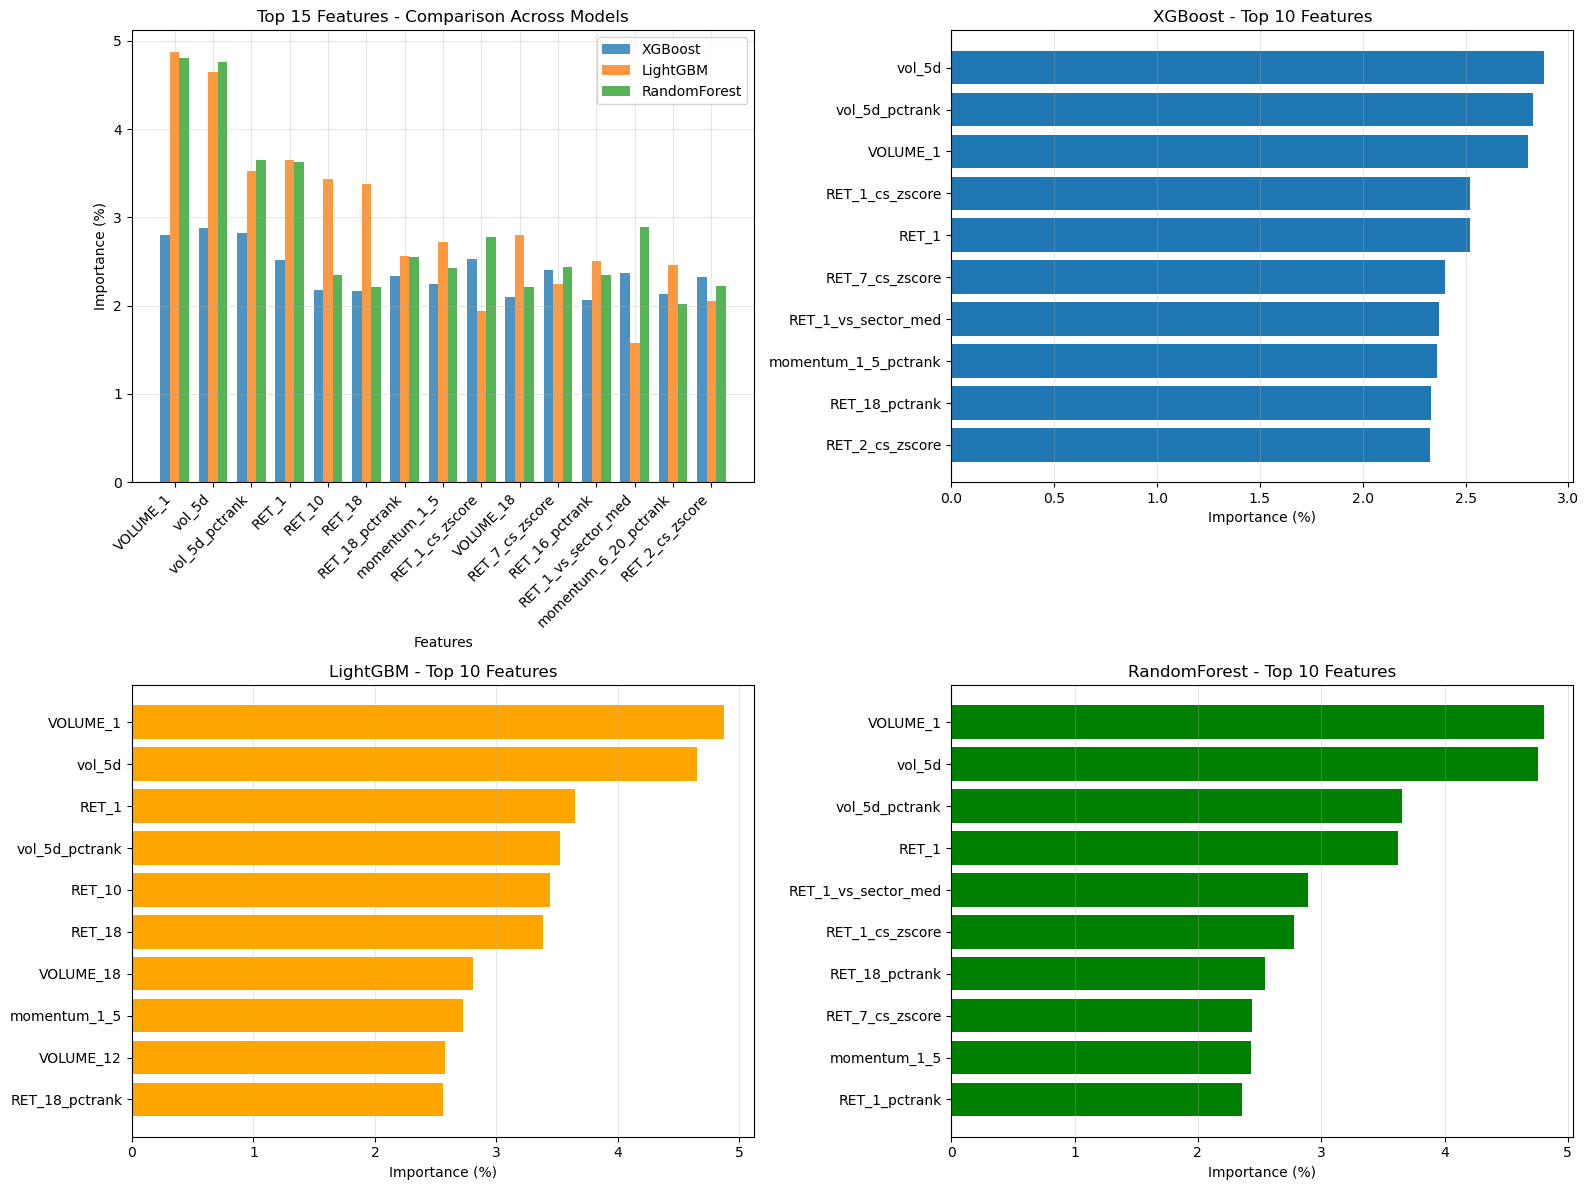


RECOMMENDED FEATURE SUBSET FOR FINAL MODEL

Features consistent across at least one model: 15
--------------------------------------------------------------------------------

Top 30 recommended features (based on consistency and average rank):
 1. RET_1
 2. RET_10
 3. RET_13_pctrank
 4. RET_16_pctrank
 5. RET_18
 6. RET_18_pctrank
 7. RET_1_cs_zscore
 8. RET_1_vs_sector_med
 9. RET_2_cs_zscore
10. VOLUME_1
11. VOLUME_12
12. VOLUME_18
13. momentum_1_5
14. vol_5d
15. vol_5d_pctrank


In [19]:

# ============================================================================
# COMPARE FEATURE IMPORTANCE BETWEEN MODELS
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE COMPARISON ACROSS MODELS")
print("="*80)

# Find features that are important in all three models
top_n_comparison = 15

xgb_top = set(xgb_importance.head(top_n_comparison)['Feature'].tolist())
lgb_top = set(lgb_importance.head(top_n_comparison)['Feature'].tolist())
rf_top = set(rf_importance.head(top_n_comparison)['Feature'].tolist())

common_all = xgb_top.intersection(lgb_top).intersection(rf_top)
common_xgb_lgb = xgb_top.intersection(lgb_top) - common_all
common_xgb_rf = xgb_top.intersection(rf_top) - common_all
common_lgb_rf = lgb_top.intersection(rf_top) - common_all
xgb_only = xgb_top - lgb_top - rf_top
lgb_only = lgb_top - xgb_top - rf_top
rf_only = rf_top - xgb_top - lgb_top

print(f"\nFeatures in top {top_n_comparison} of ALL THREE models ({len(common_all)}):")
print("-" * 60)
for i, feat in enumerate(sorted(common_all), 1):
    xgb_rank = xgb_importance[xgb_importance['Feature'] == feat].index[0] + 1
    lgb_rank = lgb_importance[lgb_importance['Feature'] == feat].index[0] + 1
    rf_rank = rf_importance[rf_importance['Feature'] == feat].index[0] + 1
    print(f"{i:2d}. {feat:35} XGB: #{xgb_rank:2d}, LGB: #{lgb_rank:2d}, RF: #{rf_rank:2d}")

print(f"\nFeatures in top {top_n_comparison} of XGBoost & LightGBM only ({len(common_xgb_lgb)}):")
print("-" * 60)
for i, feat in enumerate(sorted(common_xgb_lgb), 1):
    xgb_rank = xgb_importance[xgb_importance['Feature'] == feat].index[0] + 1
    lgb_rank = lgb_importance[lgb_importance['Feature'] == feat].index[0] + 1
    print(f"{i:2d}. {feat:35} XGB: #{xgb_rank:2d}, LGB: #{lgb_rank:2d}")

print(f"\nFeatures in top {top_n_comparison} of XGBoost & RandomForest only ({len(common_xgb_rf)}):")
print("-" * 60)
for i, feat in enumerate(sorted(common_xgb_rf), 1):
    xgb_rank = xgb_importance[xgb_importance['Feature'] == feat].index[0] + 1
    rf_rank = rf_importance[rf_importance['Feature'] == feat].index[0] + 1
    print(f"{i:2d}. {feat:35} XGB: #{xgb_rank:2d}, RF: #{rf_rank:2d}")

print(f"\nFeatures only in XGBoost top {top_n_comparison} ({len(xgb_only)}):")
print("-" * 60)
for i, feat in enumerate(sorted(xgb_only), 1):
    rank = xgb_importance[xgb_importance['Feature'] == feat].index[0] + 1
    print(f"{i:2d}. {feat:35} Rank: #{rank:2d}")

print(f"\nFeatures only in LightGBM top {top_n_comparison} ({len(lgb_only)}):")
print("-" * 60)
for i, feat in enumerate(sorted(lgb_only), 1):
    rank = lgb_importance[lgb_importance['Feature'] == feat].index[0] + 1
    print(f"{i:2d}. {feat:35} Rank: #{rank:2d}")

# ============================================================================
# VISUALIZE FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE VISUALIZATION")
print("="*80)

# Create combined feature importance DataFrame
combined_importance = pd.DataFrame({
    'XGBoost': xgb_importance.set_index('Feature')['Importance'],
    'LightGBM': lgb_importance.set_index('Feature')['Importance'],
    'RandomForest': rf_importance.set_index('Feature')['Importance']
})

# Normalize each column to 0-100 scale
combined_importance = combined_importance.apply(lambda x: 100 * x / x.sum())

# Get top 15 features by average importance
combined_importance['Average'] = combined_importance.mean(axis=1)
top_features = combined_importance.nlargest(15, 'Average')

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top features across all models
top_features_plot = top_features.drop('Average', axis=1)
x = np.arange(len(top_features_plot))
width = 0.25

axes[0, 0].bar(x - width, top_features_plot['XGBoost'], width, label='XGBoost', alpha=0.8)
axes[0, 0].bar(x, top_features_plot['LightGBM'], width, label='LightGBM', alpha=0.8)
axes[0, 0].bar(x + width, top_features_plot['RandomForest'], width, label='RandomForest', alpha=0.8)

axes[0, 0].set_xlabel('Features')
axes[0, 0].set_ylabel('Importance (%)')
axes[0, 0].set_title('Top 15 Features - Comparison Across Models')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(top_features_plot.index, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. XGBoost top features
top_xgb = combined_importance.nlargest(10, 'XGBoost')['XGBoost']
axes[0, 1].barh(range(len(top_xgb)), top_xgb.values)
axes[0, 1].set_yticks(range(len(top_xgb)))
axes[0, 1].set_yticklabels(top_xgb.index)
axes[0, 1].set_xlabel('Importance (%)')
axes[0, 1].set_title('XGBoost - Top 10 Features')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. LightGBM top features
top_lgb = combined_importance.nlargest(10, 'LightGBM')['LightGBM']
axes[1, 0].barh(range(len(top_lgb)), top_lgb.values, color='orange')
axes[1, 0].set_yticks(range(len(top_lgb)))
axes[1, 0].set_yticklabels(top_lgb.index)
axes[1, 0].set_xlabel('Importance (%)')
axes[1, 0].set_title('LightGBM - Top 10 Features')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. RandomForest top features
top_rf = combined_importance.nlargest(10, 'RandomForest')['RandomForest']
axes[1, 1].barh(range(len(top_rf)), top_rf.values, color='green')
axes[1, 1].set_yticks(range(len(top_rf)))
axes[1, 1].set_yticklabels(top_rf.index)
axes[1, 1].set_xlabel('Importance (%)')
axes[1, 1].set_title('RandomForest - Top 10 Features')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ============================================================================
# RECOMMENDED FEATURE SUBSET
# ============================================================================
print("\n" + "="*80)
print("RECOMMENDED FEATURE SUBSET FOR FINAL MODEL")
print("="*80)

# Get features that are consistently important
all_consistent = set().union(xgb_consistent, lgb_consistent, rf_consistent)

print(f"\nFeatures consistent across at least one model: {len(all_consistent)}")
print("-" * 80)

# Rank features by average importance across models
feature_rankings = {}
for feature in all_consistent:
    ranks = []
    if feature in xgb_importance['Feature'].values:
        ranks.append(xgb_importance[xgb_importance['Feature'] == feature].index[0] + 1)
    if feature in lgb_importance['Feature'].values:
        ranks.append(lgb_importance[lgb_importance['Feature'] == feature].index[0] + 1)
    if feature in rf_importance['Feature'].values:
        ranks.append(rf_importance[rf_importance['Feature'] == feature].index[0] + 1)
    
    feature_rankings[feature] = np.mean(ranks)

# Sort by average rank
sorted_features = sorted(feature_rankings.items(), key=lambda x: x[1])

print("\nTop 30 recommended features (based on consistency and average rank):")
for i, (feature, avg_rank) in enumerate(sorted_features[:30], 1):
    print(f"{i:2d}. {feature}")

- RET1, VOLUME1, and vol5d show consistently strong performance
- XGBoost has 3 unique top-15 features, suggesting it captures different patterns
- LightGBM shows some divergence with VOLUME_18 and different momentum features
- Features span different time horizons (RET_1, RET_16, RET_18)
- Both raw returns and normalized versions (pctrank, zscore) are important
- Volume features appear at multiple timeframes


With these hyper-parameters, the model overfits on the test set, so I trained the final model with fewer estimators and depths.

# Final training (experiment)

In [20]:
scaler_final = StandardScaler()
X_train_scaled_full = scaler_final.fit_transform(X_train_imputed)
X_test_scaled = scaler_final.transform(X_test_imputed)

print(f"Training set shape: {X_train_scaled_full.shape}")
print(f"Test set shape: {X_test_scaled.shape}")


Training set shape: (418595, 49)
Test set shape: (198429, 49)


In [21]:
model_final = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.6,
    colsample_bylevel=0.6,
    min_child_weight=10,
    reg_alpha=0.5,
    reg_lambda=2.0,
    gamma=0.1,
    random_state=42
)

model_final.fit(X_train_scaled_full, y_train, verbose=False)
y_test_pred_proba = model_final.predict_proba(X_test_scaled)[:, 1]
# pred_df = pd.DataFrame({
#     'proba': y_test_pred_proba,
#     'DATE': test_eng['DATE'].values     # or test['DATE'].values
# })

# date_median = pred_df.groupby('DATE')['proba'].transform('median')
# y_test_pred = (pred_df['proba'] > date_median).astype(int).values
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

submission = pd.DataFrame({
    'ID': test["ID"].values,  # Use the index from your imputed test set
    'RET': y_test_pred.astype(bool)
})

# Sort by ID to match expected order
submission = submission.sort_values('ID').reset_index(drop=True)
submission.to_csv('submission_statistical_v2.csv', index=False)

print(f"\n✓ Predictions saved!")
print(f"✓ Shape: {submission.shape}")
print(f"\nPrediction distribution:")
print(submission['RET'].value_counts(normalize=True))

pd.DataFrame({
    'feature': selected_features,
    'importance': model_final.feature_importances_
}).sort_values('importance', ascending=False).head(20)


✓ Predictions saved!
✓ Shape: (198429, 2)

Prediction distribution:
RET
True     0.501147
False    0.498853
Name: proportion, dtype: float64


,feature,importance
34,vol_5d,0.039723
36,RET_1_vs_sector_med,0.031728
37,VOLUME_1,0.031290
38,RET_1,0.031045
35,RET_1_cs_zscore,0.030257
12,RET_13_pctrank,0.029845
48,ret_vol_ratio,0.029574
0,RET_1_pctrank,0.028912
17,RET_18_pctrank,0.028587
45,RET_7_cs_zscore,0.027866


- The top features are all cross‑sectional / relative: sector‑relative return, cs z‑scores, percentile ranks, and volatility rank dominate, which matches the “predict winners within date” objective.

- vol_5d and ret_vol_ratio being top suggests the model really uses risk‑adjusted momentum and recent volatility as core signals.

- Both raw (RET_1, VOLUME_1, RET_18, VOLUME_18) and ranked/standardized versions appear, showing the model likes having both absolute and relative information, not only ranks.

- Medium‑horizon ranks (RET_10_pctrank, RET_13_pctrank, RET_16_pctrank, RET_18_pctrank) and momentum summaries (momentum_1_5_pctrank, momentum_6_20_pctrank) are important, which fits a cross‑sectional momentum story more than ultra‑short‑term noise.



In [22]:
model_lgb_final = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.02,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=30,
    reg_alpha=1.0,
    reg_lambda=3.0,
    random_state=42,
    verbose=-1
)
model_lgb_final.fit(X_train_imputed, y_train)

pd.DataFrame({
    'feature': selected_features,
    'importance': model_lgb_final.feature_importances_
}).sort_values('importance', ascending=False).head(20)


,feature,importance
37,VOLUME_1,340
34,vol_5d,251
32,vol_5d_pctrank,190
47,RET_18,169
38,RET_1,158
43,VOLUME_18,155
45,RET_7_cs_zscore,136
39,RET_2_cs_zscore,136
46,RET_10,135
15,RET_16_pctrank,131


RF importances you showed are very consistent with the XGB ones:

- Huge weight on liquidity/vol (VOLUME_1, VOLUME_18, VOLUME_12, vol_5d, vol_5d_pctrank).

- Strong recent and medium‑term momentum (RET_1, RET_18, RET_3_pctrank, RET_11_pctrank, RET_13_pctrank, RET_16_pctrank, RET_17_pctrank, RET_18_pctrank, momentum_1_5, momentum_1_5_pctrank, momentum_6_20_pctrank).

- Cross‑sectional standardization still matters (RET_1_cs_zscore, RET_7_cs_zscore, RET_2_cs_zscore)

-> Ensembles will likely help by smoothing variance rather than discovering completely new signals.


In [23]:
model_lgb_final = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.02,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=30,
    reg_alpha=1.0,
    reg_lambda=3.0,
    random_state=42,
    verbose=-1
)
model_lgb_final.fit(X_train_imputed, y_train)

pd.DataFrame({
    'feature': selected_features,
    'importance': model_lgb_final.feature_importances_
}).sort_values('importance', ascending=False).head(20)

,feature,importance
37,VOLUME_1,340
34,vol_5d,251
32,vol_5d_pctrank,190
47,RET_18,169
38,RET_1,158
43,VOLUME_18,155
45,RET_7_cs_zscore,136
39,RET_2_cs_zscore,136
46,RET_10,135
15,RET_16_pctrank,131


In [26]:
model_rf_final = RandomForestClassifier(
                n_estimators=500,
                max_depth=6,
                min_samples_split=20,
                min_samples_leaf=10,
                max_features='sqrt',
                random_state=42 + fold,
                n_jobs=-1
            )
model_rf_final.fit(X_train_imputed, y_train)

pd.DataFrame({
    'feature': selected_features,
    'importance': model_rf_final.feature_importances_
}).sort_values('importance', ascending=False).head(20)

,feature,importance
34,vol_5d,0.078260
37,VOLUME_1,0.073014
38,RET_1,0.051633
32,vol_5d_pctrank,0.049199
36,RET_1_vs_sector_med,0.044163
35,RET_1_cs_zscore,0.037933
45,RET_7_cs_zscore,0.032617
0,RET_1_pctrank,0.032246
20,RET_1_sector_pctrank,0.029413
17,RET_18_pctrank,0.027998


In [29]:
print(f"\n✓ Predictions saved!")
print(f"✓ Shape: {submission.shape}")
print(f"\nPrediction distribution:")
print(submission['RET'].value_counts(normalize=True))


✓ Predictions saved!
✓ Shape: (198429, 2)

Prediction distribution:
RET
True     0.500693
False    0.499307
Name: proportion, dtype: float64


The submission score is good. 0.5152760983474406. Still need to check 

# Ensemble

In [30]:
# Generate predictions
xgb_pred_proba = model_final.predict_proba(X_test_scaled)[:, 1]
lgb_pred_proba = model_lgb_final.predict_proba(X_test_imputed)[:, 1]
rf_pred_proba = model_rf_final.predict_proba(X_test_imputed)[:, 1]

In [31]:
# Average ensemble (XGB+LGB)
ensemble_pred_proba = 0.5 * xgb_pred_proba + 0.5 * lgb_pred_proba
ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)
# ensemble_df = pd.DataFrame({
#     'proba': ensemble_pred_proba,
#     'DATE': test_eng['DATE'].values     # or test['DATE']
# })
# date_median = ensemble_df.groupby('DATE')['proba'].transform('median')
# ensemble_pred = (ensemble_df['proba'] > date_median).astype(int).values

submission = pd.DataFrame({
    'ID': test["ID"].values,
    'RET': ensemble_pred.astype(bool)
})
submission = submission.sort_values('ID').reset_index(drop=True)
submission.to_csv('submission_ensemble_lgb+xgb.csv', index=False)

print("Predictions saved!")
print(f"Shape: {submission.shape}")
print("\nPrediction distribution:")
print(submission['RET'].value_counts(normalize=True))
print("\nFirst few predictions:")
print(submission.head())

Predictions saved!
Shape: (198429, 2)

Prediction distribution:
RET
True     0.500693
False    0.499307
Name: proportion, dtype: float64

First few predictions:
       ID    RET
0  418595  False
1  418596  False
2  418597   True
3  418598   True
4  418599  False


Submission score: 0.5150, suggesting overfitting for ensemble model with XGB and LGBM. 
I adjusted the hyper-parameters to avoid overfit, but at the same time that causes the model to underperform. Signals are missing. So I focus more on trying different features. 

In [40]:
# Average ensemble (XGB+RF)
ensemble_pred_proba = 0.9 * xgb_pred_proba + 0.1 * rf_pred_proba
ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)
submission = pd.DataFrame({
    'ID': test["ID"].values,
    'RET': ensemble_pred.astype(bool)
})
submission = submission.sort_values('ID').reset_index(drop=True)
submission.to_csv('submission_ensemble_lgb+xgb.csv', index=False)

print("Predictions saved!")
print(f"Shape: {submission.shape}")
print("\nPrediction distribution:")
print(submission['RET'].value_counts(normalize=True))


Predictions saved!
Shape: (198429, 2)

Prediction distribution:
RET
True     0.501787
False    0.498213
Name: proportion, dtype: float64

First few predictions:
       ID    RET
0  418595  False
1  418596  False
2  418597   True
3  418598  False
4  418599  False
